In [3]:
import pandas as pd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBRegressor

In [4]:
df = pd.read_csv('train.csv')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                912 non-null    int64  
 1   laptop_ID         912 non-null    int64  
 2   Company           912 non-null    object 
 3   Product           912 non-null    object 
 4   TypeName          912 non-null    object 
 5   Inches            912 non-null    float64
 6   ScreenResolution  912 non-null    object 
 7   Cpu               912 non-null    object 
 8   Ram               912 non-null    object 
 9   Memory            912 non-null    object 
 10  Gpu               912 non-null    object 
 11  OpSys             912 non-null    object 
 12  Weight            912 non-null    object 
 13  Price_euros       912 non-null    float64
dtypes: float64(2), int64(2), object(10)
memory usage: 99.9+ KB


In [6]:
df.columns

Index(['id', 'laptop_ID', 'Company', 'Product', 'TypeName', 'Inches',
       'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight',
       'Price_euros'],
      dtype='object')

In [7]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Profiling Report")
profile.to_file("your_report.html")

c:\Users\Andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 100.84it/s]


In [8]:
df_clean= df.copy()
df_clean.head(2)

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,697,705,Asus,Chromebook Flip,2 in 1 Convertible,12.5,Full HD / Touchscreen 1920x1080,Intel Core M M3-6Y30 0.9GHz,4GB,64GB Flash Storage,Intel HD Graphics 515,Chrome OS,1.2kg,669.0
1,435,442,Asus,Rog Strix,Gaming,17.3,Full HD 1920x1080,AMD Ryzen 1600 3.2GHz,8GB,256GB SSD + 1TB HDD,AMD Radeon RX 580,Windows 10,3.2kg,1695.0


In [9]:
df_clean.columns

Index(['id', 'laptop_ID', 'Company', 'Product', 'TypeName', 'Inches',
       'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight',
       'Price_euros'],
      dtype='object')

In [10]:
from sklearn.preprocessing import OneHotEncoder



In [11]:
product_families = {
    # Gaming
    'Rog': 'Gaming', 'Omen': 'Gaming', 'Predator': 'Gaming',
    'Legion': 'Gaming', 'Alienware': 'Gaming', 'Gt': 'Gaming',
    'Gs': 'Gaming', 'Ge': 'Gaming', 'Gl': 'Gaming', 'Gp': 'Gaming',
    
    # Business/Pro
    'Thinkpad': 'Business', 'Thinkpad': 'Business', 
    'Elitebook': 'Business', 'Probook': 'Business',
    'Latitude': 'Business', 'Precision': 'Business',
    'Tecra': 'Business', 'Portege': 'Business', 'Zbook': 'Business',
    
    # Consumer
    'IdeaPad': 'Consumer', 'Inspiron': 'Consumer', 'Vostro': 'Consumer',
    'Aspire': 'Consumer', 'Pavilion': 'Consumer', 'Vivobook': 'Consumer',
    'Chromebook': 'Consumer', 'Yoga': 'Consumer', 'Envy': 'Consumer',
    
    # Ultrabooks/Premium
    'Xps': 'Premium', 'Spectre': 'Premium', 'Zenbook': 'Premium',
    'Macbook': 'Premium', 'Surface': 'Premium', 'Matebook': 'Premium',
    'Pixelbook': 'Premium'
}

def get_product_family(product_name):
    product_lower = product_name.lower()
    for key, family in product_families.items():
        if key.lower() in product_lower:
            return family
    return 'Other'


# Función para extraer specs del string entre paréntesis
def extract_specs_from_parentheses(product_string):
    specs = {
        'has_specs_in_name': 0,
        'cpu_in_name': 0,
        'ram_in_name': 0,
        'storage_in_name': 0,
        'gpu_in_name': 0
    }
    
    if '(' in product_string:
        specs['has_specs_in_name'] = 1
        inside = product_string.split('(')[1].split(')')[0].lower()
        
        # Buscar componentes específicos
        if any(cpu_term in inside for cpu_term in ['i3', 'i5', 'i7', 'i9', 'ryzen', 'a6', 'a9', 'e2']):
            specs['cpu_in_name'] = 1
        if 'gb' in inside:
            specs['ram_in_name'] = 1
        if any(storage in inside for storage in ['tb', 'gb', 'ssd', 'hdd']):
            specs['storage_in_name'] = 1
        if any(gpu in inside for gpu in ['radeon', 'geforce', 'quadro', 'gpu']):
            specs['gpu_in_name'] = 1
    
    return pd.Series(specs)

In [12]:
def extract_cpu_line(cpu_string):
    cpu_lower = cpu_string.lower()
    
    # Prioridad de búsqueda
    if 'core i7' in cpu_lower: return 'Core i7'
    elif 'core i5' in cpu_lower: return 'Core i5'
    elif 'core i3' in cpu_lower: return 'Core i3'
    elif 'xeon' in cpu_lower: return 'Xeon'
    elif 'ryzen' in cpu_lower: return 'Ryzen'
    elif 'pentium' in cpu_lower: return 'Pentium'
    elif 'celeron' in cpu_lower: return 'Celeron'
    elif 'core m' in cpu_lower: return 'Core M'
    elif 'atom' in cpu_lower: return 'Atom'
    elif 'a12' in cpu_lower: return 'A12'
    elif 'a10' in cpu_lower: return 'A10'
    elif 'a9' in cpu_lower: return 'A9'
    elif 'a8' in cpu_lower: return 'A8'
    elif 'a6' in cpu_lower: return 'A6'
    elif 'a4' in cpu_lower: return 'A4'
    elif 'e-series' in cpu_lower: return 'E-Series'
    else: return 'Other'

def estimate_cpu_generation(cpu_string, model_number):
    """
    Estimar generación basado en número de modelo:
    6000 = 6th gen, 7000 = 7th gen, 8000 = 8th gen, etc.
    """
    if pd.isna(model_number):
        return None
    
    # Solo para Intel Core con modelo de 4 dígitos
    if isinstance(model_number, str) and model_number.isdigit() and len(model_number) >= 4:
        first_digit = int(model_number[0])
        return first_digit
    return None
    

    # Mapeo de gama de CPU (basado en conocimiento de dominio)
cpu_tier_mapping = {
    'Xeon': 5,            # Workstation/Server
    'Core i7': 4,         # High-end
    'Core i5': 3,         # Mid-range
    'Ryzen': 4,           # High-end (AMD)
    'Core i3': 2,         # Entry-level
    'A12': 3,             # Mid-range (AMD)
    'A10': 2,             # Low-mid (AMD)
    'A9': 2,              # Low-mid (AMD)
    'A8': 2,              # Low (AMD)
    'A6': 1,              # Low (AMD)
    'A4': 1,              # Low (AMD)
    'Core M': 2,          # Low power
    'Pentium': 1,         # Budget
    'Celeron': 1,         # Budget
    'Atom': 1,            # Ultra low power
    'E-Series': 1,        # Very low end
    'Other': 1
}

In [13]:
def classify_gpu_performance(gpu_string):
    """
    Clasifica GPU en categorías de performance basado en conocimiento del mercado
    """
    if not isinstance(gpu_string, str):
        return 'integrated'
    
    gpu = gpu_string.lower()
    
    # 1. INTEGRADAS (bajo costo)
    if 'intel hd' in gpu or 'intel uhd' in gpu or 'intel iris' in gpu or 'intel graphics' in gpu:
        if 'iris pro' in gpu or 'iris plus' in gpu:
            return 'integrated_high'  # Intel Iris (mejor integrada)
        return 'integrated_low'  # Intel HD básica
    
    # 2. AMD
    elif 'amd' in gpu or 'radeon' in gpu:
        if 'rx 5' in gpu or 'rx 550' in gpu or 'rx 540' in gpu:
            return 'dedicated_low'  # AMD entry-level
        elif 'rx 580' in gpu:
            return 'dedicated_high'  # AMD high-end
        elif 'r7' in gpu or 'firepro' in gpu or 'radeon pro' in gpu:
            return 'dedicated_mid'  # AMD mid-range
        elif 'r5' in gpu or 'r4' in gpu or 'r3' in gpu or 'r2' in gpu:
            return 'dedicated_low'  # AMD very low-end
        else:
            return 'dedicated_mid'
    
    # 3. NVIDIA
    elif 'nvidia' in gpu or 'geforce' in gpu or 'quadro' in gpu:
        # GAMING HIGH-END
        if 'gtx 1080' in gpu or 'gtx 1070' in gpu or 'gtx 980' in gpu:
            return 'gaming_high'
        # GAMING MID
        elif 'gtx 1060' in gpu or 'gtx 1050' in gpu or 'gtx 970' in gpu or 'gtx 965' in gpu:
            return 'gaming_mid'
        # GAMING LOW/ENTRY
        elif 'gtx 960' in gpu or 'gtx 950' in gpu or 'gt 940' in gpu or 'mx150' in gpu or 'mx130' in gpu:
            return 'gaming_low'
        # WORKSTATION (Quadro)
        elif 'quadro' in gpu:
            if 'm3000' in gpu or 'm2200' in gpu or 'm2000' in gpu:
                return 'workstation_high'
            elif 'm1200' in gpu or 'm1000' in gpu or 'm620' in gpu or 'm520' in gpu:
                return 'workstation_mid'
            else:
                return 'workstation_low'
        # OLD/VERY LOW
        elif '920' in gpu or '930' in gpu or '150' in gpu:
            return 'dedicated_very_low'
        else:
            return 'dedicated_mid'
    
    return 'unknown'


def extract_gpu_features(gpu_string):
    """
    Extrae características específicas de la GPU
    """
    features = {
        'gpu_manufacturer': 'unknown',
        'is_dedicated_gpu': 0,
        'is_gaming_gpu': 0,
        'is_workstation_gpu': 0,
        'is_integrated_gpu': 0,
        'gpu_model_number': None,
        'gpu_vram_estimate': 0  # Estimación en GB basada en modelo
    }
    
    if not isinstance(gpu_string, str):
        return pd.Series(features)
    
    gpu = gpu_string.lower()
    
    # Fabricante
    if 'intel' in gpu:
        features['gpu_manufacturer'] = 'intel'
        features['is_integrated_gpu'] = 1
    elif 'amd' in gpu or 'radeon' in gpu:
        features['gpu_manufacturer'] = 'amd'
        features['is_dedicated_gpu'] = 1
    elif 'nvidia' in gpu or 'geforce' in gpu or 'quadro' in gpu:
        features['gpu_manufacturer'] = 'nvidia'
        features['is_dedicated_gpu'] = 1
    
    # Tipo específico
    if 'geforce' in gpu:
        features['is_gaming_gpu'] = 1
    elif 'quadro' in gpu:
        features['is_workstation_gpu'] = 1
    elif 'radeon pro' in gpu or 'firepro' in gpu:
        features['is_workstation_gpu'] = 1
    
    # Extraer número de modelo (ej: 1060 de "GTX 1060")
    model_match = re.search(r'(gtx?\s*\d{3,4}|quadro\s*\w+\d+|rx\s*\d{3,4}|\d{3,4}[a-z]*)', gpu, re.IGNORECASE)
    if model_match:
        features['gpu_model_number'] = model_match.group(0).strip().upper()
    
    # Estimación de VRAM basada en modelo (conocimiento de dominio)
    if 'gtx 1080' in gpu or 'gtx 1070' in gpu or 'rx 580' in gpu:
        features['gpu_vram_estimate'] = 8
    elif 'gtx 1060' in gpu or 'gtx 980' in gpu or 'gtx 970' in gpu:
        features['gpu_vram_estimate'] = 6
    elif 'gtx 1050' in gpu or 'gtx 960' in gpu or 'quadro m2200' in gpu:
        features['gpu_vram_estimate'] = 4
    elif 'gtx 950' in gpu or '940mx' in gpu or 'rx 540' in gpu or 'rx 550' in gpu:
        features['gpu_vram_estimate'] = 2
    elif 'mx150' in gpu or 'mx130' in gpu or '930mx' in gpu or '920mx' in gpu:
        features['gpu_vram_estimate'] = 2
    elif features['is_integrated_gpu'] == 1:
        features['gpu_vram_estimate'] = 0  # Comparte memoria del sistema
    
    return pd.Series(features)

# Mapeo de performance score (0-10)
gpu_performance_score = {
    'gaming_high': 9,
    'workstation_high': 9,
    'gaming_mid': 7,
    'dedicated_high': 8,
    'workstation_mid': 7,
    'gaming_low': 5,
    'dedicated_mid': 6,
    'workstation_low': 5,
    'dedicated_low': 4,
    'integrated_high': 3,
    'dedicated_very_low': 2,
    'integrated_low': 1,
    'unknown': 0
}

In [14]:
#COLUMNA MEMORY
def parse_memory(memory_string):
    """
    Extrae múltiples features de almacenamiento de un string como:
    '256GB SSD + 1TB HDD' o '512GB SSD'
    """
    features = {
        'total_capacity_gb': 0,
        'has_ssd': 0,
        'has_hdd': 0,
        'has_flash': 0,
        'has_hybrid': 0,
        'ssd_capacity_gb': 0,
        'hdd_capacity_gb': 0,
        'flash_capacity_gb': 0,
        'hybrid_capacity_gb': 0,
        'is_dual_drive': 0,
        'primary_type': 'unknown',
        'secondary_type': 'none'
    }
    
    # Normalizar string
    mem = memory_string.lower().replace(' ', '').replace('storage', '')
    
    # Dividir por '+' si hay múltiples drives
    parts = mem.split('+')
    features['is_dual_drive'] = 1 if len(parts) > 1 else 0
    
    drives = []
    for part in parts:
        # Extraer capacidad
        capacity_match = re.search(r'(\d+\.?\d*)(tb|gb|mb)', part)
        if capacity_match:
            value = float(capacity_match.group(1))
            unit = capacity_match.group(2)
            
            # Convertir todo a GB
            if unit == 'tb':
                capacity_gb = value * 1024
            elif unit == 'gb':
                capacity_gb = value
            elif unit == 'mb':
                capacity_gb = value / 1024
            
            # Identificar tipo
            drive_type = 'unknown'
            if 'ssd' in part:
                drive_type = 'ssd'
                features['has_ssd'] = 1
                features['ssd_capacity_gb'] += capacity_gb
            elif 'hdd' in part or 'hard' in part:
                drive_type = 'hdd'
                features['has_hdd'] = 1
                features['hdd_capacity_gb'] += capacity_gb
            elif 'flash' in part:
                drive_type = 'flash'
                features['has_flash'] = 1
                features['flash_capacity_gb'] += capacity_gb
            elif 'hybrid' in part:
                drive_type = 'hybrid'
                features['has_hybrid'] = 1
                features['hybrid_capacity_gb'] += capacity_gb
            
            drives.append({'type': drive_type, 'capacity_gb': capacity_gb})
    
    # Ordenar drives por capacidad (mayor primero)
    drives.sort(key=lambda x: x['capacity_gb'], reverse=True)
    
    # Calcular capacidad total
    features['total_capacity_gb'] = sum(d['capacity_gb'] for d in drives)
    
    # Asignar tipos primario y secundario
    if drives:
        features['primary_type'] = drives[0]['type']
        if len(drives) > 1:
            features['secondary_type'] = drives[1]['type']
    
    return pd.Series(features)

# Clasificación de capacidad total (baja/media/alta)
def classify_capacity(total_gb):
    if total_gb < 256:
        return 'low'
    elif total_gb < 1024:  # 1TB
        return 'medium'
    else:
        return 'high'


In [15]:
def clean_columns(df_clean):
    #COLUMNA ID - ELIMINAR - QUITAR DEL X ❌

    #COLUMNA LAPTOP ID - ELIMINAR - QUITAR DEL X❌

    #COLUMNA COMPANY - No hay que hacer cambios, directamente hacer ONEHOT🔥

    #COLUMNA PRODUCT - QUITAR DEL X✅❌

    # Extraer solo la parte antes del primer paréntesis (o todo si no hay paréntesis)
    df_clean['ProductBase'] = df_clean['Product'].apply(lambda x: x.split('(')[0].strip() if '(' in x else x.strip())
    # Limpiar espacios extra y estandarizar nombres similares
    df_clean['ProductBase'] = df_clean['ProductBase'].str.replace('  ', ' ')
    df_clean['ProductBase'] = df_clean['ProductBase'].str.strip()
    # Estandarizar nombres (ej: 'Rog Strix' y 'ROG Strix' -> mismo)
    df_clean['ProductBase'] = df_clean['ProductBase'].str.title()
    #Genero nueva columna para separar en familias de producto
    df_clean['ProductFamily'] = df_clean['ProductBase'].apply(get_product_family)
    # Aplicar la función
    specs_features = df_clean['Product'].apply(extract_specs_from_parentheses)
    df_clean = pd.concat([df_clean, specs_features], axis=1)

    #COLUMNA TYPENAME - No hay que hacer cambios, directamente hacer ONEHOT🔥❌

    #COLUMNA INCHES - No hay que hacer cambios, directamente ESCALAR🪜

    #COLUMNA SCREENRESOLUTION - QUITAR DE LA X❌
    
    #Nueva conlumna para extraer resolución de pantalla y separo por la altura y el ancho, genero nueva variable de ratio

    df_clean['ScreenResolutionNumber'] = df_clean['ScreenResolution'].str.extract(r'(\d+x\d+)')[0]
    df_clean[['ResWidth', 'ResHeight']] = df_clean['ScreenResolutionNumber'].str.split('x', expand=True).astype(float)
    df_clean['AspectRatio'] = df_clean['ResWidth'] / df_clean['ResHeight']
    #Nuevas columnas para estraer las palabras claves
    df_clean['Touchscreen'] = df_clean['ScreenResolution'].str.contains('Touchscreen', case=False).astype(int)
    df_clean['IPS'] = df_clean['ScreenResolution'].str.contains('IPS Panel', case=False).astype(int)
    df_clean['Retina'] = df_clean['ScreenResolution'].str.contains('Retina', case=False).astype(int)
    df_clean['4K'] = df_clean['ScreenResolution'].str.contains('4K|Ultra HD', case=False).astype(int)
    df_clean['FullHD'] = df_clean['ScreenResolution'].str.contains('Full HD', case=False).astype(int)
    df_clean['QuadHD'] = df_clean['ScreenResolution'].str.contains('Quad HD', case=False).astype(int)
    
    #COLUMNA CPU -QUITAR DE LA X❌

    # Extraer fabricante
    df_clean['CpuManufacturer'] = df_clean['Cpu'].apply(
        lambda x: 'Intel' if 'Intel' in x else ('AMD' if 'AMD' in x else 'Other'))
    # Extraer línea/serie (ej: Core i7, Ryzen, Celeron, etc.)
    df_clean['CpuLine'] = df_clean['Cpu'].apply(extract_cpu_line)
    # Extraer número de modelo (ej: 7500U de "Intel Core i7 7500U 2.7GHz")
    df_clean['CpuModelNumber'] = df_clean['Cpu'].str.extract(r'(\d{4}[A-Z]*|\d{3}[A-Z]*)')[0]
    # Extraer frecuencia en GHz (convertir a numérico)
    df_clean['CpuFrequencyGHz'] = df_clean['Cpu'].str.extract(r'(\d+\.?\d*)GHz')[0].astype(float)
    # Detectar si es de bajo voltaje (U) o alta performance (HQ, HK)
    df_clean['CpuIsLowVoltage'] = df_clean['Cpu'].str.contains('U$|U\s', regex=True).astype(int)
    df_clean['CpuIsHighPerformance'] = df_clean['Cpu'].str.contains('HQ|HK|H', regex=True).astype(int)
    df_clean['CpuIsQuadCore'] = df_clean['Cpu'].str.contains('Quad', case=False).astype(int)
    df_clean['CpuIsDualCore'] = df_clean['Cpu'].str.contains('Dual', case=False).astype(int)
    # Estimar generación basado en número de modelo: 6000 = 6th gen, 7000 = 7th gen, 8000 = 8th gen, etc."""
    df_clean['CpuGeneration'] = df_clean.apply(lambda row: estimate_cpu_generation(row['Cpu'], row['CpuModelNumber']), axis=1)
    # Mapeo de gama de CPU (basado en conocimiento de dominio)
    df_clean['CpuTier'] = df_clean['CpuLine'].map(cpu_tier_mapping)
    # Score compuesto de performance aproximada
    df_clean['CpuPerformanceScore'] = (
        df_clean['CpuTier'] * 2 + 
        df_clean['CpuFrequencyGHz'].fillna(2.0) / 2 +
        df_clean['CpuIsHighPerformance'] * 1.5 -
        df_clean['CpuIsLowVoltage'] * 0.5)
    # Variables binarias útiles
    df_clean['CpuIsIntel'] = (df_clean['CpuManufacturer'] == 'Intel').astype(int)
    df_clean['CpuIsAMD'] = (df_clean['CpuManufacturer'] == 'AMD').astype(int)
    df_clean['CpuIsCorei7'] = (df_clean['CpuLine'] == 'Core i7').astype(int)
    df_clean['CpuIsCorei5'] = (df_clean['CpuLine'] == 'Core i5').astype(int)
    # Algunos valores pueden tener problemas de formato
    df_clean['CpuFrequencyGHz'] = pd.to_numeric(df_clean['CpuFrequencyGHz'], errors='coerce')
    df_clean['CpuFrequencyGHz'] = df_clean['CpuFrequencyGHz'].fillna(df_clean['CpuFrequencyGHz'].median())
    # Interacción entre CPU y RAM podría ser poderosa
    df_clean['CpuTier_Ram_Interaction'] = df_clean['CpuTier'] * df_clean['Ram']
    
    #COLUMNA GPU - QUITAR DE LA X
    df_clean['GpuCategory'] = df_clean['Gpu'].apply(classify_gpu_performance)
    gpu_features =df_clean['Gpu'].apply(extract_gpu_features)
    df_clean = pd.concat([df_clean, gpu_features], axis=1)
    df_clean['GpuPerformanceScore'] =df_clean['GpuCategory'].map(gpu_performance_score)
    # Features combinadas útiles
    df_clean['HasDedicatedGpu'] =df_clean['is_dedicated_gpu']
    df_clean['HasGamingGpu'] =df_clean['is_gaming_gpu']
    df_clean['HasWorkstationGpu'] =df_clean['is_workstation_gpu']
    # Interacción con CPU (gaming setup típico)
    df_clean['GamingSetup'] = ((df_clean['HasGamingGpu'] == 1) & 
                            (df_clean['CpuLine'].isin(['Core i7', 'Core i5']))).astype(int)
    # Interacción con RAM (workstation setup)
    df_clean['WorkstationSetup'] = ((df_clean['HasWorkstationGpu'] == 1) & 
                                    (df_clean['CpuLine'].isin(['Core i7', 'Xeon']))).astype(int)
    # Algunos valores tienen espacios extra o caracteres especiales
    df_clean['Gpu'] = df_clean['Gpu'].str.strip()
    df_clean['Gpu'] = df_clean['Gpu'].str.replace('  ', ' ')
    # "Premium Gaming" = High-end GPU + High-end CPU + SSD
    # df_clean['PremiumGaming'] = ((df_clean['GPU_gaming_high'] == 1) & 
    #                             (df_clean['CpuIsCorei7'] == 1) & 
    #                             (df_clean['is_ssd_only'] == 1)).astype(int)

    # # "Budget" = Integrated GPU + HDD only
    # df_clean['BudgetConfig'] = ((df_clean['is_integrated_gpu'] == 1) & 
    #                             (df_clean['is_hdd_only'] == 1)).astype(int)


    #COLUMNA RAM  - Quito el GB de los valores y lo convierto a numerico - ESCALAR
    df_clean['Ram'] = df_clean['Ram'].str.replace('GB', '').astype(int)
    
    #COLUMNA MEMORY - QUITAR DEL X
    # Aplicar la función
    memory_features = df_clean['Memory'].apply(parse_memory)
    df_clean = pd.concat([df_clean, memory_features], axis=1)
    # Proporción de SSD sobre capacidad total
    df_clean['ssd_ratio'] = df_clean['ssd_capacity_gb'] / df_clean['total_capacity_gb'].replace(0, 1)
    # ¿Es solo SSD? (característica premium)
    df_clean['is_ssd_only'] = ((df_clean['has_ssd'] == 1) & 
                            (df_clean['has_hdd'] == 0) & 
                            (df_clean['has_hybrid'] == 0)).astype(int)
    # ¿Es solo HDD? (característica económica)
    df_clean['is_hdd_only'] = ((df_clean['has_hdd'] == 1) & 
                            (df_clean['has_ssd'] == 0) & 
                            (df_clean['has_hybrid'] == 0)).astype(int)
    # ¿Tiene SSD para sistema operativo? (SSD >= 128GB)
    df_clean['has_os_ssd'] = (df_clean['ssd_capacity_gb'] >= 128).astype(int)
    df_clean['capacity_class'] = df_clean['total_capacity_gb'].apply(classify_capacity)   
    # Costo aproximado de almacenamiento (proxy de valor)
    # Valores estimados por GB: SSD $0.20/GB, HDD $0.03/GB, Flash $0.50/GB, Hybrid $0.10/GB
    df_clean['storage_value_score'] = (
        df_clean['ssd_capacity_gb'] * 0.20 +
        df_clean['hdd_capacity_gb'] * 0.03 +
        df_clean['flash_capacity_gb'] * 0.50 +
        df_clean['hybrid_capacity_gb'] * 0.10)
    # Velocidad estimada del almacenamiento (proxy de performance)
    df_clean['storage_speed_score'] = (
        df_clean['ssd_capacity_gb'] * 10 +
        df_clean['flash_capacity_gb'] * 8 +
        df_clean['hybrid_capacity_gb'] * 4 +
        df_clean['hdd_capacity_gb'] * 1) / df_clean['total_capacity_gb'].replace(0, 1)


    #COLUMNA OPSYS - No hay que hacer nada, directamente ONEHOT
    #COLUMNA WEIGHT - Quitamos el kg de los valores y convertimos a numerico
    df_clean['Weight'] = df_clean['Weight'].str.replace('kg', '').astype(float)
    
    return df_clean

df_clean = clean_columns(df_clean)


In [16]:
df_clean.shape

(912, 80)

In [17]:
cols = df_clean.columns
for col in cols:
    if df_clean[col].dtype == 'object':
        print(col)
    else:
        continue


Company
Product
TypeName
ScreenResolution
Cpu
Memory
Gpu
OpSys
ProductBase
ProductFamily
ScreenResolutionNumber
CpuManufacturer
CpuLine
CpuModelNumber
CpuTier_Ram_Interaction
GpuCategory
gpu_manufacturer
gpu_model_number
primary_type
secondary_type
capacity_class


In [18]:
df_clean['capacity_class'].nunique()

3

ONEHOT 
- Company
- TypeName
- OpSys
- ProductFamily
- CpuManufacturer
- CpuLine
- CpuTier_Ram_Interaction
- GpuCategory
- gpu_manufacturer
- primary_type
- secondary_type
- capacity_class

QUITAR X 
- id
- laptop_ID
- Product
- ScreenResolution
- Cpu
- Gpu
- Memory
 - gpu_model_number
 - ProductBase
 - CpuModelNumber

In [19]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 80 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       912 non-null    int64  
 1   laptop_ID                912 non-null    int64  
 2   Company                  912 non-null    object 
 3   Product                  912 non-null    object 
 4   TypeName                 912 non-null    object 
 5   Inches                   912 non-null    float64
 6   ScreenResolution         912 non-null    object 
 7   Cpu                      912 non-null    object 
 8   Ram                      912 non-null    int64  
 9   Memory                   912 non-null    object 
 10  Gpu                      912 non-null    object 
 11  OpSys                    912 non-null    object 
 12  Weight                   912 non-null    float64
 13  Price_euros              912 non-null    float64
 14  ProductBase              9

In [20]:
X = df_clean.drop(['id', 'laptop_ID','Product','ScreenResolution','Cpu','Gpu','Memory','gpu_model_number','ProductBase','CpuModelNumber','Price_euros'], axis=1)
y = df_clean['Price_euros']

In [21]:
print(df_clean.shape)
print(X.shape)

(912, 80)
(912, 69)


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(729, 69)
(183, 69)
(729,)
(183,)


In [24]:
col_numericas = ['Inches','Weight','Ram' ]
col_categoricas = ['Company','TypeName','OpSys','ProductFamily','CpuManufacturer','CpuLine','CpuTier_Ram_Interaction','GpuCategory','gpu_manufacturer','primary_type','secondary_type','capacity_class']

In [25]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
import numpy as np

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Crear pipeline para variables numéricas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


# Combinar pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, col_numericas),
    ('cat', cat_pipeline, col_categoricas)
])

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBRegressor(n_estimators=100, random_state=42))
])

param_grid = {
    'classifier__n_estimators': [450,350,400, 500],
    'classifier__booster': ['gbtree','gblinear'],
    'classifier__learning_rate': [0.1,0.15,0.17], 
    'classifier__max_depth':[2,3,4,5]
}


grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid_search.fit(X, y)

print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Inches', 'Weight', 'Ram']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignor

In [26]:
# 7. Resultados
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor MAE (validación): {-grid_search.best_score_:.4f}")

# 8. Evaluar en test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print(f"MAE en test: {test_mae:.4f}")

Mejores parámetros: {'classifier__booster': 'gbtree', 'classifier__learning_rate': 0.15, 'classifier__max_depth': 3, 'classifier__n_estimators': 400}
Mejor MAE (validación): 179.3934
MAE en test: 80.6012


In [27]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print(f"MAE en test: {test_mae:.4f}")


MAE en test: 80.6012


In [28]:
df_test = pd.read_csv('test.csv')
df_test.shape

(391, 13)

In [29]:
df_test_pred = clean_columns(df_test)
df_test_pred.shape

(391, 79)

In [30]:
df_test_pred = df_test_pred.drop(['id', 'laptop_ID','Product','ScreenResolution','Cpu','Gpu','Memory','gpu_model_number','ProductBase','CpuModelNumber'], axis=1)

df_test_pred.shape

(391, 69)

In [31]:
predicciones = best_model.predict(df_test_pred)

In [32]:
df_id = df_test['id']

In [33]:
resultados = pd.DataFrame({
    'id': df_test['id'].values,  # Usar .values para evitar problemas de índices
    'precio_predicho': predicciones
})
resultados.head()



,id,precio_predicho
0,824,1905.857666
1,101,316.834717
2,1157,1995.870239
3,940,1312.409302
4,853,1683.438965


In [34]:
resultados.to_csv('predicciones.csv', index=False)

In [35]:
! pip install optuna


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import optuna

In [29]:
X.head()

,Company,TypeName,Inches,Ram,OpSys,Weight,ProductFamily,has_specs_in_name,cpu_in_name,ram_in_name,...,is_dual_drive,primary_type,secondary_type,ssd_ratio,is_ssd_only,is_hdd_only,has_os_ssd,capacity_class,storage_value_score,storage_speed_score
0,Asus,2 in 1 Convertible,12.5,4,Chrome OS,1.20,Consumer,0,0,0,...,0,flash,none,0.0,0,0,0,low,32.00,8.0
1,Asus,Gaming,17.3,8,Windows 10,3.20,Gaming,0,0,0,...,1,hdd,ssd,0.2,0,0,1,high,81.92,2.8
2,Lenovo,Notebook,15.6,4,Windows 10,1.85,Other,1,1,1,...,0,hdd,none,0.0,0,1,0,high,30.72,1.0
3,Dell,Ultrabook,13.3,16,Windows 10,1.29,Premium,0,0,0,...,0,ssd,none,1.0,1,0,1,medium,102.40,10.0
4,Lenovo,Notebook,15.6,4,Windows 7,2.32,Other,1,1,1,...,0,hybrid,none,0.0,0,0,0,high,102.40,4.0


In [ ]:
pca_pipe = make_pipeline(StandardScaler(), PCA(n_components=4))
pca_pipe.fit(X)

modelo_pca = pca_pipe['pca']

In [ ]:
modelo_pca.components_

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Crear pipeline para variables numéricas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combinar pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, col_numericas),
    ('cat', cat_pipeline, col_categoricas)
])

full_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

In [42]:
X_processed = preprocessor.fit_transform(X)

In [45]:
feature_names = preprocessor.get_feature_names_out()
len(feature_names)

109

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)  # o el número que decidas
X_pca = pca.fit_transform(X_processed)

In [50]:
pca.n_components_

50

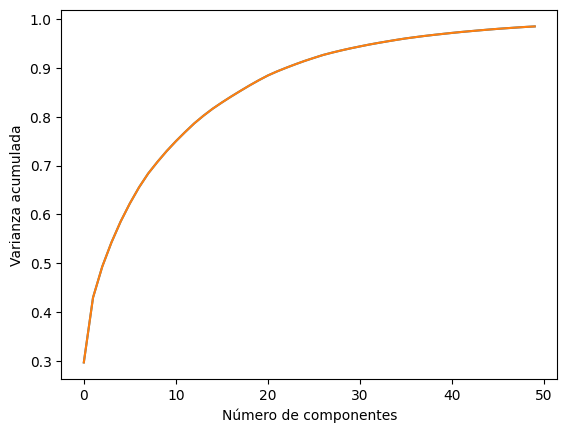

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.show()

In [52]:
pd.DataFrame(
    data = pca.components_,
    columns = pca.columns,
)

AttributeError: 'PCA' object has no attribute 'columns'